# **IMPORT**

In [6]:
import numpy as np
import sympy as smp
from sympy import symbols, Eq, solve
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from tabulate import tabulate
import matplotlib
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy
from scipy.signal import savgol_filter
from scipy.signal import resample

In [7]:
def mean(arr):
    return np.mean(arr)

def error(x):
    return x.std() / np.sqrt(x.size)

In [8]:
matplotlib.rcParams.update({
    'font.family': 'serif',
})

In [4]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# **FUNCTIONS** - definitions

## Data load

In [1]:
base_url = 'http://golem.fjfi.cvut.cz/shotdir/{}'

def load_oscope(shot, oscope, sensor):
    
    '''
    Nacita data z osciloskopu. 
    
    Sensor:
    {U_Loop, U_BtCoil, U_RogCoil, U_photod} 
    '''
    
    osc = dict(
        z='RigolDS1104Z-a',
        a='RigolMSO5104-a',
        b='RigolMSO5204-b',
        c='RigolMSO5204-c',
        d='RigolMSO5204-d',)
    
    url = base_url.format(shot) + '/Devices/Oscilloscopes/{}/RemoteTrainingOsc/{}.csv'.format(osc[oscope],sensor)
 
    t,data = np.genfromtxt(url, delimiter=',', unpack=True, skip_footer=1) 
    
    return t,data

def load(shot, sensor):
    
    '''Nacita data ze standartni diagnostiky, promenna sensor 
    
    Sensor:
    {U_Loop, U_BtCoil, U_RogCoil, U_IntBtCoil} 
    
    '''

    url = base_url.format(shot) + '/Diagnostics/BasicDiagnostics/DetectPlasma/{}.csv'.format(sensor)
    
    t,data = np.genfromtxt(url, delimiter=',', unpack=True, skip_footer=1) 
    
    return t,data

def load_Ip(shot):
    url = base_url.format(shot) + '/Diagnostics/BasicDiagnostics/Basic/Results/Ip.csv'
    t,data = np.genfromtxt(url, delimiter=',', unpack=True, skip_footer=1) 
    
    return t,data


def load_system_parameter(shot,parameter):
    url = base_url.format(shot) + '/Production/Parameters/SystemParameters/{}'.format(parameter)
    return float(np.loadtxt(url))


def load_discharge_parameter(shot,parameter):
    url = base_url.format(shot) + '/Operation/Discharge/{}'.format(parameter)
    return float(np.loadtxt(url))


In [2]:
import urllib.request
data = urllib.request.urlopen(base_url.format(41524) + '/comment')

for line in data:
    print(line)

b'PRAK san ubt skupiny 4\n'


## Plotovani

In [3]:
def oscope_print(shot, o):

    plt_labels = ['$U_l$','$U_{Bt}$','$U_{RC}$','$U_{p}$']
    labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_photod']
    data = []

    for name in labels:
        data.append(load_oscope(shot,o,name)[1])
        t = load_oscope(shot,o,name)[0]

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6),sharex=True, layout="constrained")

    for i in range(4):
        axs[i//2][i%2].plot(t*1000,savgol_filter(data[i],20,5), color = 'k', lw = .6)
        axs[i//2][i%2].set_title(plt_labels[i])
    
    fig.suptitle('Osciloskop, shot No.{}'.format(shot))
    


In [4]:
def diag_print(shot):
    
    '''Plotuje data ze standatdni diagnostiky'''

    plt_labels = ['$U_l$','$U_{Bt}$','$U_{RC}$','$B_{t}$']
    labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_IntBtCoil']
    data = []

    for name in labels:
        data.append(load(shot,name)[1])
        t = load(shot,name)[0]

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6),sharex=True, layout="constrained")

    for i in range(4):
        axs[i//2][i%2].plot(t*1000,savgol_filter(data[i],40,5), color = 'k', lw = .6)
        axs[i//2][i%2].set_title(plt_labels[i])
    
    fig.suptitle('Standartni diagnostika, shot No.{}'.format(shot))

In [5]:
def plot(x,y):
    plt.plot(x,y, color = 'k', lw = .6)
    
    
def plot_comparsion(x1,y1,x2,y2):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 3), layout="constrained")

    axs[0].plot(x1,y1, color = 'k', lw = '.6')
    axs[1].plot(x2,y2, color = 'k', lw = '.6')

    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

### Obsolete

In [36]:
def oscope_print_vertical(shot, o):
    
    '''Plotuje data z osciloskopu s oznacenim o...oznaceni viz sekce data load'''
    
    t, Ul = load_oscope(shot,o,'U_Loop')
    t, Ubt = load_oscope(shot,o,'U_BtCoil')
    t, Urc = load_oscope(shot,o,'U_RogCoil')
    t, Up = load_oscope(shot,o,'U_photod')
    
    fig, axs = plt.subplots(4, sharex=True,figsize=(6,12))
    
    axs[0].plot(t*1000,Ul, color = 'k', lw = '.6')
    axs[1].plot(t*1000,Ubt, color = 'k', lw = '.6')
    axs[2].plot(t*1000,Urc, color = 'k', lw = '.6')
    axs[3].plot(t*1000,Up, color = 'k', lw = '.6')

    axs[0].set_title('$U_l$')
    axs[1].set_title('$U_{Bt}$')
    axs[2].set_title('$U_{RC}$')
    axs[3].set_title('$U_{p}$')

In [61]:
def diag_print_vertical(shot):
    
    '''Plotuje data ze standatdni diagnostiky'''
    
    t, Ul = load(shot,'U_Loop')
    t, Ubt = load(shot,'U_BtCoil')
    t, Urc = load(shot,'U_RogCoil')
    t, Bt = load(shot,'U_IntBtCoil')
    
    fig, axs = plt.subplots(4, sharex=True,figsize=(6,12))
    axs[0].plot(t*1000,Ul, color = 'k', lw = '.6')
    axs[1].plot(t*1000,Ubt, color = 'k', lw = '.6')
    axs[2].plot(t*1000,Urc, color = 'k', lw = '.6')
    axs[3].plot(t*1000,Bt, color = 'k', lw = '.6')
    
    axs[0].set_title('$U_l$')
    axs[1].set_title('$U_{Bt}$')
    axs[2].set_title('$U_{RC}$')
    axs[3].set_title('$B_{t}$')

    fig.suptitle('Standartni diagnostika')

# **MERENI** - vizualizace on spot

Uzitecne ploty pro mereni a naslednou vizualizaci dat. Nasleduje nastaveni cisla vystrelu __shot__ a pismenko osciloskopu __oscope__ dle:

*   a = RigolMSO5104-a  
*   b = RigolMSO5204-b  
*   c = RigolMSO5204-c  
*   d = RigolMSO5204-d  
*   z = RigolDS1104Z-a    
     
__NA WEBU OZNACENI JINAK!!!__

In [10]:
shot = 41510
oscope = 'd'

### **Standartni diagnostika**

Graf zakladnich dat merenych standardni diagnostikou - tj. to co uz na tokamaku bylo.  
  
__Data "vyhlazeny" pomoci Savitzky-Golay filtru__



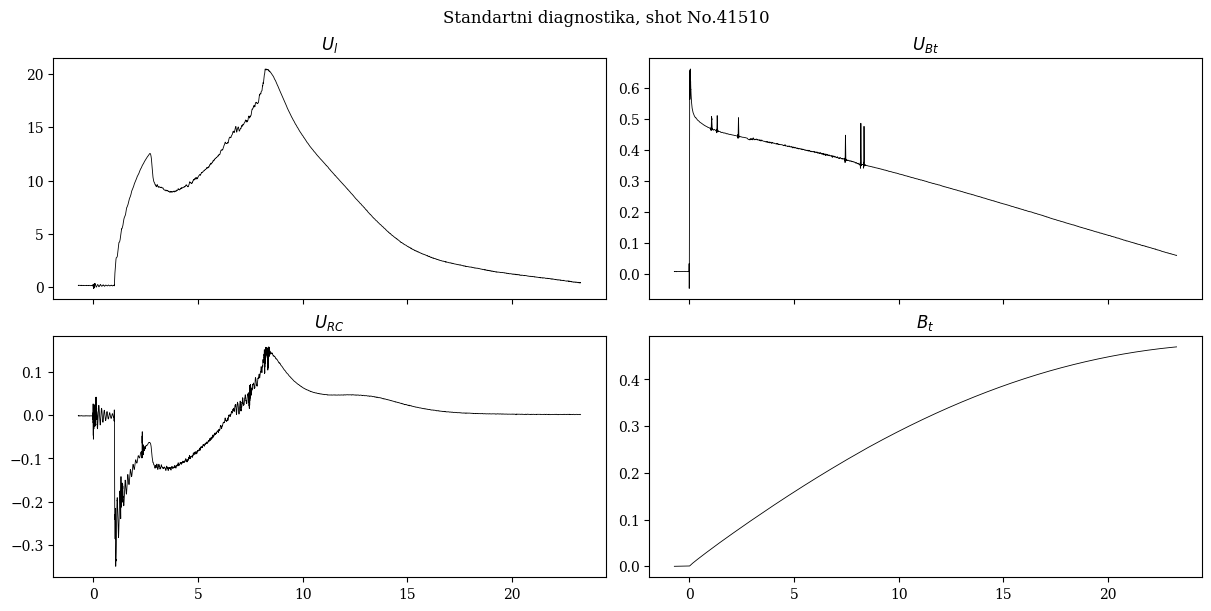

In [14]:
diag_print(shot) #### Plot standartni diagnostiky

### **Osciloskop**

Graf zakladnich dat merenych osciloskopem - tj. sondy co jsme umistili pro nase mereni

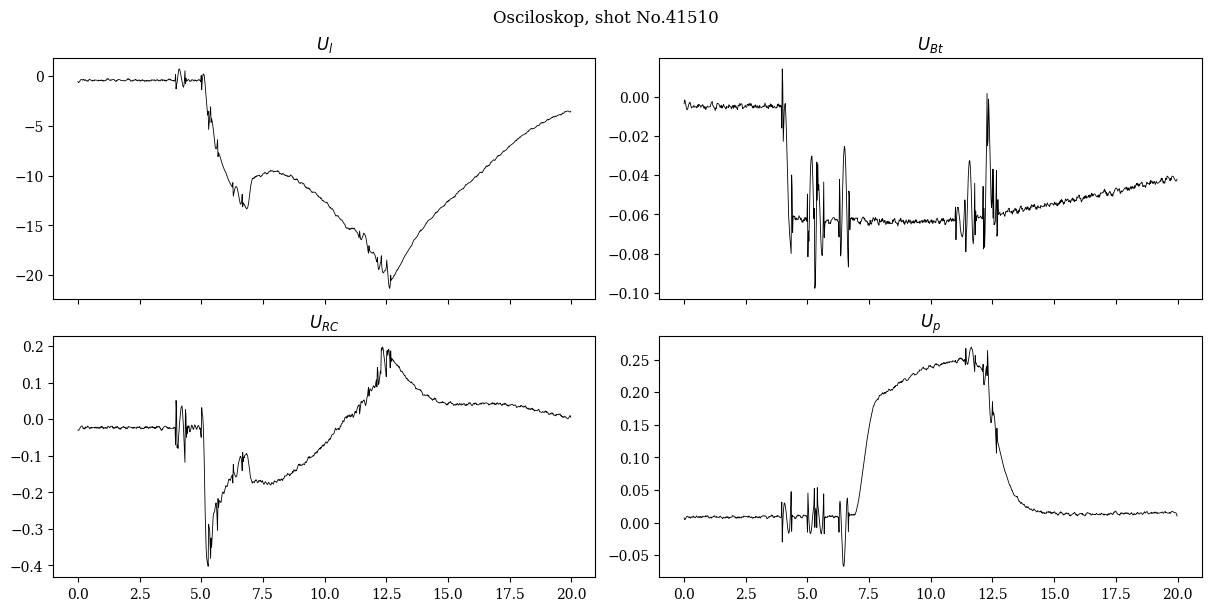

In [15]:
oscope_print(shot,oscope) #### Print osciloskopu

### **Srovnani cehokoliv s cimkoliv**

Pro srovnani __U_Loop, U_BtCoil__ nebo __U_RogCoil__ z osciloskopu a standartni diagnostiky, staci nastavit promenou sensor:

In [384]:
sensor = 'U_Loop' ### {U_Loop, U_BtCoil, U_RogCoil} 
sign = -1 ### Pokud jsou data z osciloskopu opacneho znamenka, staci obratit znamenko zde

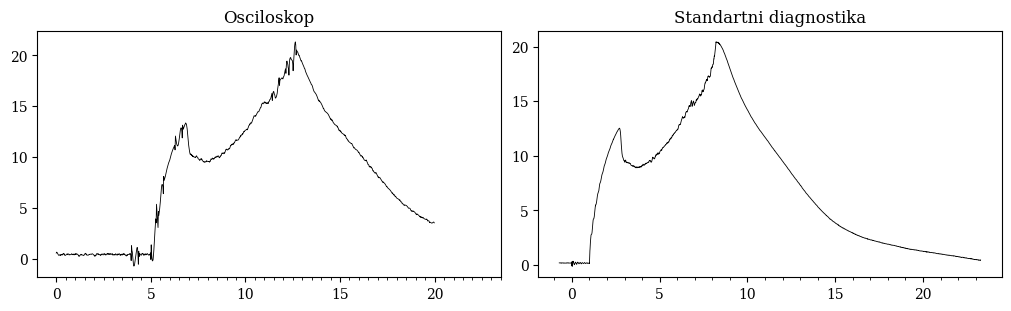

In [386]:
t,U = load_oscope(shot,oscope,sensor) # Nacteni napeti z civky merici toroidalni pole
t_diag,U_diag = load(shot,sensor) # Nacteni toroidalniho pole ze standartni diag.

U = savgol_filter(U,20,5)
U_diag = savgol_filter(U_diag,30,3)

fig, axs = plt.subplots(ncols=2, figsize=(10, 3), layout="constrained")

axs[0].plot(t*1000,sign*U, color = 'k', lw = '.6')
axs[1].plot(t_diag*1000,U_diag, color = 'k', lw = '.6')
axs[0].set_title('Osciloskop')
axs[1].set_title('Standartni diagnostika')
axs[1].set_xticks(np.arange(-1,24,1),minor = True)
axs[0].set_xticks(np.arange(0,24,.5),minor = True)

plt.show()

### **Srovnani $B_t$**

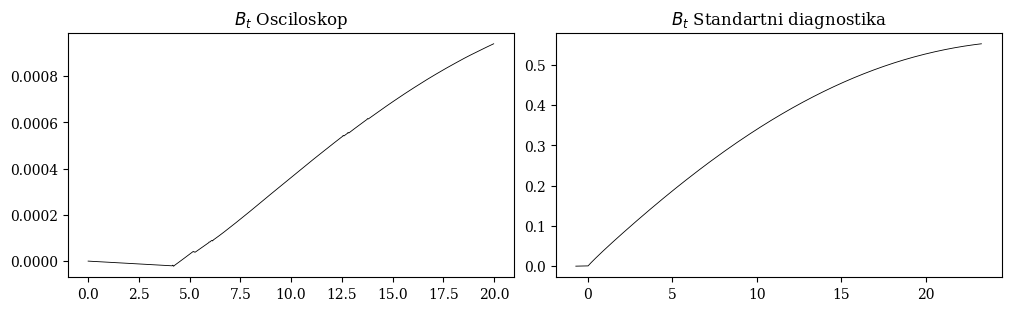

In [174]:
t,Ubt = load_oscope(shot,oscope,'U_BtCoil') # Nacteni napeti z civky merici toroidalni pole
t_diag,Bt_diag = load(shot,'U_IntBtCoil') # Nacteni toroidalniho pole ze standartni diag.

Bt = cumulative_trapezoid(Ubt,t,initial=0) # Integrace napeti toroidalniho pole

fig, axs = plt.subplots(ncols=2, figsize=(10, 3), layout="constrained")

axs[0].plot(t*1000,Bt, color = 'k', lw = '.6')
axs[1].plot(t_diag*1000,Bt_diag, color = 'k', lw = '.6')
axs[0].set_title('$B_t$ Osciloskop')
axs[1].set_title('$B_t$ Standartni diagnostika')

plt.show()

# **ZPRACOVANI** - doma

### Global Params

Definice a nacteni dulezitych konstant a tabulka parametru vystrelu. 

Tady se nastavi vsechny vystrely ze serie do __shots__ a pismenko osciloskopu __oscope__ (viz dle sekce MERENI nebo FUNCTIONS->data load):

In [9]:
shots = [41510,41511,41512,41514,41515] # Cisla vystrelu, pro ktere probiha zpracovani
oscope = 'd' # Oznaceni osciloskopu, viz sekce Data load

In [10]:
osc = dict(
        z='RigolDS1104Z-a',
        a='RigolMSO5104-a',
        b='RigolMSO5204-b',
        c='RigolMSO5204-c',
        d='RigolMSO5204-d',)

Tady se nactou uzitecne konstanty (odpor komory a Crc z stdiag).  
!!! Je treba nastavit __t_step__ jako velikost kroku casove osy osciloskopu !!!

In [11]:
Crc_diag = load_system_parameter(shots[0],'K_RogowskiCoil') 
Rch = load_system_parameter(shots[0],'R_chamber')

kb = 1.38*10**(-23)
eV = 1.602*10**(-19)
Vp = ufloat(57*10**(-3),5*10**(-3))
Vch = 150*10**(-3)


t_step = 20/1000 ### krok casove osy v ms, zde rozsah 20ms pri 1000 krocich (merenych hodnot)

Tady je treba nastavit __t_offset__. Je to cas v milisekundach do ktereho se budou brat data pro odecteni offsetu. Tj. konstantni cast pred vybojem.  

In [12]:
t_offset = 3 ### cas v ms do ktereho je prumerovano pro odecet ofsetu
offset_index = t_offset/t_step ### index tohoto casu

In [ ]:
t_diag = load(shots[0],'U_Loop')[0]## casova osa std diag
diag_step = (t_diag[-1]-t_diag[0])/len(t_diag) ### nejmensi dilek std diag
shift = (-t_diag[0])/diag_step
offset_index_diag = int(shift)

### **Tabulka vystrelu**

In [15]:
p_r,U_bt,U_cd,t_cd,p_real = [],[],[],[],[]

for s in shots:
    p_r.append(load_discharge_parameter(s,'p_working_gas_discharge_request'))
    U_bt.append(load_discharge_parameter(s,'U_bt_discharge_request'))
    U_cd.append(load_discharge_parameter(s,'U_cd_discharge_request'))
    t_cd.append(load_discharge_parameter(s,'t_cd_discharge_request'))
    p_real.append(load_discharge_parameter(s,'p_chamber_pressure_predischarge'))
    

In [34]:
tab = np.array([shots,p_r,U_bt,U_cd,t_cd,p_real]).T
headers = ['Shot No.', 'p_r', 'U_bt', 'U_cd','t_cd','p_real']

print(tabulate(tab, headers, tablefmt="github"))

|   Shot No. |   p_r |   U_bt |   U_cd |   t_cd |   p_real |
|------------|-------|--------|--------|--------|----------|
|      41510 |    13 |    800 |    500 |   1000 |     13.6 |
|      41511 |    13 |    820 |    500 |   1000 |     14.5 |
|      41512 |    13 |    880 |    500 |   1000 |     15.4 |
|      41514 |    15 |    930 |    500 |   1000 |     21   |
|      41515 |    15 |    980 |    500 |   1000 |     23.1 |


### Plot data

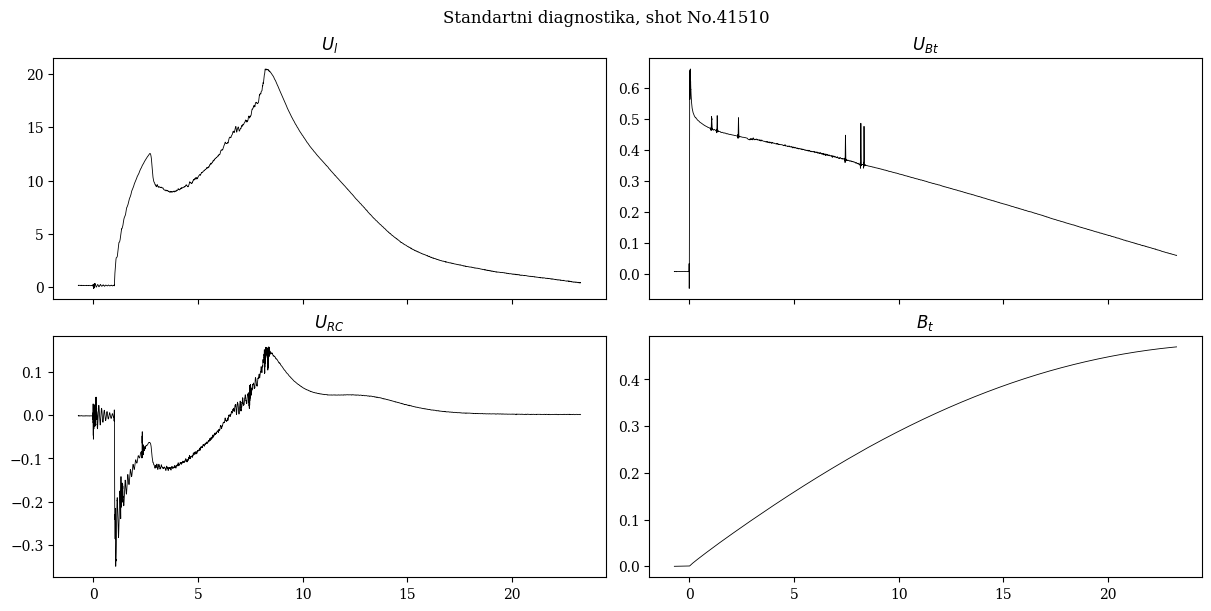

In [18]:
diag_print(shots[0])

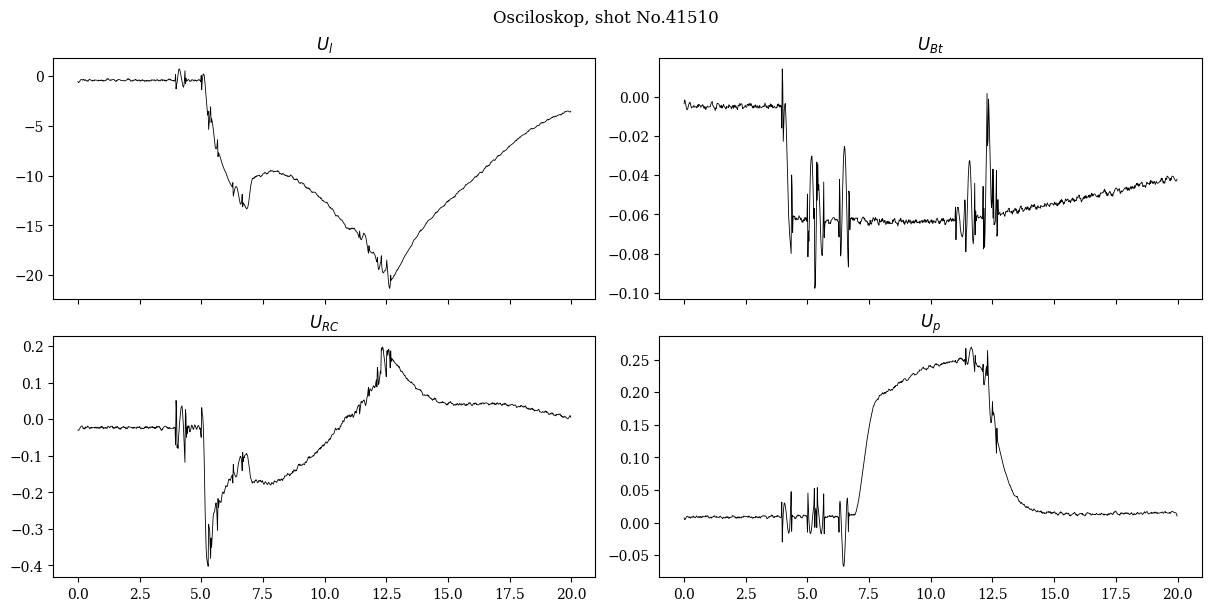

In [19]:
oscope_print(shots[0],oscope)

### **Data load**

Nacteni dat do slovniku __data__. Struktuta nasledujici:  
Keywordu predstavujicimu cislo vyboje se priradi dalsi slovnik, ktery obsahuje vsechna mozna data. Behem zpracovani budou dalsi data pridavana, zde nacteny pouze namerena data.          

In [17]:
sgn_l = -1   #### Pokud data z osciloskopu prevracena, obratit znamenko
sgn_bt = 1
sgn_rc = -1

#### Osciloskop

In [18]:
'''{'U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_photod'}'''

data = {} 

for shot in shots:
    
    d = {}

    d['U_Loop'] = sgn_l * load_oscope(shot,oscope,'U_Loop')[1]
    d['U_BtCoil'] = sgn_bt * load_oscope(shot,oscope,'U_BtCoil')[1]
    d['U_RogCoil'] = sgn_rc * load_oscope(shot,oscope,'U_RogCoil')[1]
    d['U_photod'] = load_oscope(shot,oscope,'U_photod')[1]
    d['time'] = load_oscope(shot,oscope,'U_Loop')[0]
    
    data[shot] = d
    

#### Std diag

In [19]:
'''{'U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_IntBtCoil'}'''

data_stdiag = {} 

for shot in shots:
    
    d = {}

    d['U_Loop'] = load(shot,'U_Loop')[1]
    d['U_BtCoil'] = load(shot,'U_BtCoil')[1]
    d['U_RogCoil'] = -load(shot,'U_RogCoil')[1]
    d['U_IntBtCoil'] = load(shot,'U_IntBtCoil')[1]
    d['Bt'] = load(shot,'U_IntBtCoil')[1]
    d['I_p'] = load_Ip(shot)[1]
    d['time'] = load(shot,'U_Loop')[0]
    
    data_stdiag[shot] = d

#plot(data_stdiag[shots[0]]['time'],data_stdiag[shots[0]]['I_p'])

### **Offset removal**

In [20]:
oi = int(offset_index)

for shot in shots:
    for sensor in ['U_Loop', 'U_BtCoil', 'U_RogCoil']:
        
        offset = np.mean(data[shot][sensor][0:oi])
        data[shot][sensor] -=  offset


In [21]:
oi =  offset_index_diag #700 ### Index pro odebrani offsetu z std diag

for shot in shots:
    for sensor in ['U_Loop', 'U_BtCoil', 'U_RogCoil']:
          
        offset = np.mean(data_stdiag[shot][sensor][0:oi])
        data_stdiag[shot][sensor] -=  offset
    

### **Urceni posunu dat**

Urceni posunu osciloskopu vuci standardni diagnostice

In [22]:
for shot in shots:

    t_diag = data_stdiag[shot]['time'] ## casova osa std diag
    t = data[shot]['time'] ## casov osa osciloskopu

    step_diag = t_diag[1]-t_diag[0] ### nejmensi dilek std diag
    step = t[1]-t[0] ### nejmensi dilek osciloskopu
    
    k = np.where(data[shot]['U_Loop'] > 1)[0][0]
    t_cut = t[k:] - t[k:][0]
    ##t_cut -= t_cut[0]
    
    k_diag = np.where(data_stdiag[shot]['U_Loop'] > 1)[0][0]
    t_diag_cut = t_diag[k_diag:] - t_diag[k_diag:][0]
    #t_diag_cut -= t_diag_cut[0]
    
    #plot(t_cut,data[shot]['U_Loop'][k:]) 
    #plot(t_diag_cut,data_stdiag[shot]['U_Loop'][k_diag:]) 
    
    lim = min(t_diag_cut[-1], t_cut[-1])
    
    l = int(lim/step)
    l_diag = int(lim/step_diag)

    
    data[shot]['bounds'] = (k,k+l)
    data_stdiag[shot]['bounds'] = (k_diag,k_diag+l_diag)
    
    #plot(t_cut[0:l],data[shot]['U_Loop'][k:k+l])
    #plot(t_diag_cut[0:l_diag],data_stdiag[shot]['U_Loop'][k_diag:k_diag+l_diag])
    
    #plt.show()

### **Urceni C_rc** 

In [23]:
Crc_arr = []

for shot in shots:
    
    k_d,l_d = data_stdiag[shot]['bounds']
    k,l = data[shot]['bounds']
    t_d = data_stdiag[shot]['time'][k_d:l_d]
    
    Irc = cumulative_trapezoid(data[shot]['U_RogCoil'][k:l],data[shot]['time'][k:l],initial=0)
    Irc_int = resample(Irc, l_d-k_d)
    
    Idiag = 1000*data_stdiag[shot]['I_p'][k_d:l_d] + data_stdiag[shot]['U_Loop'][k_d:l_d]/Rch
    
    Crc_arr.append(mean(Idiag)/mean(Irc_int))
    
Crc = mean(Crc_arr)
Crc_arr,Crc

([4429200.268831903,
  4347412.05888029,
  4397954.541840074,
  4277063.07366267,
  4280155.7187685985],
 4346357.132396707)

#### Plot proudu

In [24]:
shot = shots[4]

k_d,l_d = data_stdiag[shot]['bounds']
k,l = data[shot]['bounds']
t_d = data_stdiag[shot]['time'][k_d:l_d]

Irc = cumulative_trapezoid(data[shot]['U_RogCoil'][k:l],data[shot]['time'][k:l],initial=0)
Irc_int = resample(Irc, l_d-k_d)

Idiag = 1000*data_stdiag[shot]['I_p'][k_d:l_d] + data_stdiag[shot]['U_Loop'][k_d:l_d]/Rch

plot(t_d,Idiag)
plt.show()
plot(t_d,Crc*Irc_int)
plt.show()


C:\Users\stepa\AppData\Local\Temp/ipykernel_14188/1400812505.py:13: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\stepa\AppData\Local\Temp/ipykernel_14188/1400812505.py:15: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### **Proud v plazmatu I_p**

Vypocet proudu v plazmatu $I_p$ podle:  
 
 $I_{p}(t)=C_{R C}\int_{0}^{t}U_{R C}(\tau)d\tau-{\frac{U_{l}(t)}{R_{ch}}}.$

In [25]:
for shot in shots:
    
    Ul = data[shot]['U_Loop']
    Urc = data[shot]['U_RogCoil'] - mean(data[shot]['U_RogCoil'][0:10])
    t = data[shot]['time']
    
    Ichp = Crc*cumulative_trapezoid(Urc,t,initial=0) ### Integral Urc
    
    Ip = Ichp - Ul/Rch
        
    data[shot]['I_p'] = Ip  ## Ulozeni dat
    data[shot]['I_chp'] = Ichp


#### Plot

In [26]:
shot = shots[2]

plt.figure(figsize = (10,3))
#plot(t*1000, smooth(data[shot]['I_chp']-data[shot]['I_p'], 20) )
plot(t*1000, savgol_filter(data[shot]['I_chp']-data[shot]['I_p'], 30,3) )
#plot(t*1000, smooth(data[shot]['I_p'], 20) )
plot(t*1000, savgol_filter(data[shot]['I_p'], 30,3) )

plt.ylim(0,2300)
plt.xlim(2,20)
plt.title('Our diagnostics')

plt.figure(figsize = (10,3))
plot(data_stdiag[shot]['time']*1000+4, data_stdiag[shot]['I_p']*1000)
plt.xlim(2,20)
plt.ylim(0,2300)
plt.title('Standard diagnostics')

Text(0.5, 1.0, 'Standard diagnostics')

### **Electron density**

In [44]:
p0 = []

for shot in shots:
    p0.append(load_discharge_parameter(shot,'p_chamber_pressure_predischarge')*10**(-3))
    data[shot]['p_0'] = load_discharge_parameter(shot,'p_chamber_pressure_predischarge')*10**(-3)
    
p0 = np.array(p0)
p0

array([0.0136, 0.0145, 0.0154, 0.021 , 0.0231])

In [68]:


for shot in shots:
    p0 = load_discharge_parameter(shot,'p_chamber_pressure_predischarge')*10**(-3)
    data[shot]['n_e'] = (2*p0*Vch)/(kb*300*Vp)
    
    print(data[shot]['n_e'])
    
#n_e = (2*p0*Vch)/(k*300*Vp)
#print(n_e)

(1.73+/-0.15)e+19
(1.84+/-0.16)e+19
(1.96+/-0.17)e+19
(2.67+/-0.23)e+19
(2.94+/-0.26)e+19


### **B-toroidal**

In [29]:
Cbt_arr = []

for shot in shots:
    
    k_d,l_d = data_stdiag[shot]['bounds']
    k,l = data[shot]['bounds']
    t_d = data_stdiag[shot]['time'][k_d:l_d]
    
    Bt = cumulative_trapezoid(data[shot]['U_BtCoil'][k:l],data[shot]['time'][k:l],initial=0)
       
    Bt_int = resample(Bt, l_d-k_d)
    
    Bt_diag = data_stdiag[shot]['U_IntBtCoil'][k_d:l_d]
    
    Cbt_arr.append(mean(Bt_diag)/mean(Bt_int))
    
Cbt = mean(Cbt_arr[1:-1])

for shot in shots:
    Bt = cumulative_trapezoid(data[shot]['U_BtCoil'],data[shot]['time'],initial=0)
    data[shot]['Bt'] = Cbt*Bt

Cbt_arr,Cbt

([-526.1846917437146,
  467.03733081357115,
  555.3280033438555,
  492.1627904148196,
  490.1171098023925],
 504.84270819074874)

#### Plot

In [30]:
shot = shots[4]

k_d,l_d = data_stdiag[shot]['bounds']
k,l = data[shot]['bounds']
t_d = data_stdiag[shot]['time'][k_d:l_d]

#Bt = Cbt*cumulative_trapezoid(data[shot]['U_BtCoil'][k:l],data[shot]['time'][k:l],initial=0)
Bt = data[shot]['Bt']
Bt_int = resample(Bt, l_d-k_d)

Bt_diag = data_stdiag[shot]['U_IntBtCoil'][k_d:l_d]

plot(t[k:l]-t[k],data[shot]['Bt'][k:l])
plt.show()
plot(t_d,Bt_diag)
plt.show()

C:\Users\stepa\AppData\Local\Temp/ipykernel_14188/2812587886.py:14: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\stepa\AppData\Local\Temp/ipykernel_14188/2812587886.py:16: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### **Stredovani**

Stredovani hodnot v kvazistacionarni fazi.  
Promenne __start__ a __stop__ nastavit jako krajni body kvazistac. intervalu v casove ose osciloskopu. (v milisekundach)

In [31]:
start = 9
end = 12

In [32]:
for shot in shots:

    a,b = int(start/t_step), int(end/t_step) ### Odhad intervalu kvazistac. faze
    
    Ip = data[shot]['I_p'][a:b]
    Ul = data[shot]['U_Loop'][a:b]
    Bt = data[shot]['Bt'][a:b]
    
    data[shot]['Ip_mean'] = np.array((mean(Ip), error(Ip)))
    data[shot]['U_Loop_mean'] = np.array((mean(Ul), error(Ul)))
    data[shot]['Bt_mean'] = np.array((mean(Bt), error(Bt)))
    
    print('Ip: {}  Ul: {}, Bt: {}'.format(ufloat(mean(Ip), error(Ip)), ufloat(mean(Ul), error(Ul)), ufloat(mean(Bt), error(Bt)) ))

Ip: 1431+/-19  Ul: 13.51+/-0.18, Bt: -0.1822+/-0.0021
Ip: 1764+/-18  Ul: 12.39+/-0.20, Bt: 0.2096+/-0.0024
Ip: 1795+/-14  Ul: 11.59+/-0.17, Bt: 0.1863+/-0.0022
Ip: 1836+/-15  Ul: 11.37+/-0.15, Bt: 0.2179+/-0.0025
Ip: 1477+/-11  Ul: 11.17+/-0.10, Bt: 0.2266+/-0.0027


### **Teplota**

Vypocet teploty plazmatu

In [33]:
for shot in shots:
    
    Ip_avg = ufloat(data[shot]['Ip_mean'][0],data[shot]['Ip_mean'][1])
    Ul_avg = ufloat(data[shot]['U_Loop_mean'][0],data[shot]['U_Loop_mean'][1])
    
    Rp = Ul_avg/Ip_avg
    T = 0.9*Rp**(-2/3)
    
    data[shot]['R_p'] = Rp
    data[shot]['T_e'] = T
    
    #print(r'{} & ({:.1uL}) \\'.format(shot,T)) # Latex print
    
    print(r'| {} | {:.1u} |'.format(shot,T))

| 41510 | 20.1+/-0.3 |
| 41511 | 24.5+/-0.3 |
| 41512 | 26.0+/-0.3 |
| 41514 | 26.7+/-0.3 |
| 41515 | 23.4+/-0.2 |


### **Neo Alcator**

In [67]:
R = 40/100
a = 8.5/100

for shot in shots:
    
    expa = ufloat(1.04,0.19)
    expR = ufloat(2.04,0.28)
    
    n_e = data[shot]['n_e']
    
    T = 100*1.9*10**(-21)*(R**expR)*(a**expa)*n_e
    
    data[shot]['t_neo'] = T
    
    #print(r'{} & ({:.1uL}) \\'.format(shot,T)) # Latex print
    
    print(r'| {} | {:.1u} |'.format(shot,T))

| 41510 | 0.04+/-0.02 |
| 41511 | 0.04+/-0.02 |
| 41512 | 0.04+/-0.02 |
| 41514 | 0.06+/-0.03 |
| 41515 | 0.07+/-0.04 |


### **Vykon**

In [46]:
for shot in shots:
    
    Ip_avg = ufloat(data[shot]['Ip_mean'][0],data[shot]['Ip_mean'][1])
    Ul_avg = ufloat(data[shot]['U_Loop_mean'][0],data[shot]['U_Loop_mean'][1])
    
    Rp = data[shot]['R_p']
    
    P_OH = Rp * Ip_avg**2

    data[shot]['P_OH'] = P_OH
    
    print(r'| {} | {:.1u} |'.format(shot,P_OH))

| 41510 | (1.93+/-0.06)e+04 |
| 41511 | (2.19+/-0.06)e+04 |
| 41512 | (2.08+/-0.05)e+04 |
| 41514 | (2.09+/-0.05)e+04 |
| 41515 | (1.65+/-0.03)e+04 |


### **Electron energy**

In [47]:
for shot in shots:
    
    T = data[shot]['T_e']
    n_e = data[shot]['n_e']
    
    Wp = Vp * (n_e*k*T*eV)/3
    
    data[shot]['W_p'] = Wp
    
    print(r'| {} | {:.1u} |'.format(shot,Wp))

| 41510 | 221+/-3 |
| 41511 | 286+/-4 |
| 41512 | 322+/-4 |
| 41514 | 451+/-5 |
| 41515 | 434+/-3 |


| 41510 | (1.46+/-0.02)e-23 |  
| 41511 | (1.78+/-0.02)e-23 |  
| 41512 | (1.89+/-0.02)e-23 |  
| 41514 | (1.94+/-0.02)e-23 |  
| 41515 | (1.70+/-0.01)e-23 |  

### **Electron confinement time**

In [48]:
for shot in shots:
    
    T = data[shot]['T_e']
    n_e = data[shot]['n_e']
    
    Ip_avg = ufloat(data[shot]['Ip_mean'][0],data[shot]['Ip_mean'][1])
    Ul_avg = ufloat(data[shot]['U_Loop_mean'][0],data[shot]['U_Loop_mean'][1])
    
    te = 1000*n_e*eV*T*Vp/(3*Ip_avg*Ul_avg)
      
    data[shot]['t_e'] = te
       
    print(te)
    

0.0549+/-0.0013
0.0630+/-0.0015
0.0744+/-0.0015
0.1039+/-0.0019
0.1266+/-0.0017


In [ ]:
(3.64+/-0.08)e-27
(3.92+/-0.09)e-27
(4.36+/-0.09)e-27
(4.47+/-0.08)e-27
(4.94+/-0.07)e-27

# **TABULKY A GRAFY DO PROTOKOLU**

Vypsane keywords slovniku data. Obsahuje (temer) vsechna zdrojova i zpracovana data.

In [49]:
print(data[shots[1]].keys()) 

dict_keys(['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_photod', 'time', 'bounds', 'I_p', 'I_chp', 'p_0', 'n_e', 'Bt', 'Ip_mean', 'U_Loop_mean', 'Bt_mean', 'R_p', 'T_e', 'T_neo', 't_neo', 'P_OH', 'W_p', 't_e'])


In [41]:
print(data_stdiag[shots[0]].keys()) 

dict_keys(['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_IntBtCoil', 'Bt', 'I_p', 'time', 'bounds'])


## Tabulka - vyseldne hodnodty

Tabulka, poradi:    Shot No. - $I_\mathrm{p}$ - $U_\mathrm{l}$ - $B_\mathrm{t}$ - $T_\mathrm{e}$ - $\tau_\mathrm{e}$

In [68]:
print(r'Shot No. & $I_\mathrm{p}$ & $U_\mathrm{l}$ & $B_\mathrm{t}$ & $T_\mathrm{e}$ & $\tau_\mathrm{e}$ & $\tau_\mathrm{neo}$ \\')
print('\hline \hline')

for shot in shots:
    Ip = ufloat(*data[shot]['Ip_mean'])
    Ul = ufloat(*data[shot]['U_Loop_mean'])
    Bt = ufloat(*data[shot]['Bt_mean'])
    T = data[shot]['T_e']
    t = data[shot]['t_e']
    t_neo = data[shot]['t_neo']

    print(r'${}$ & ${:L}$ & ${:.1uL}$ & ${:.1uL}$ & ${:.1uL}$ & ${:.1uL}$ & ${:.1uL}$ \\'.format(shot,Ip,Ul,Bt,T,t,t_neo))

Shot No. & $I_\mathrm{p}$ & $U_\mathrm{l}$ & $B_\mathrm{t}$ & $T_\mathrm{e}$ & $\tau_\mathrm{e}$ & $\tau_\mathrm{neo}$ \\
\hline \hline
$41510$ & $1431 \pm 19$ & $13.5 \pm 0.2$ & $-0.182 \pm 0.002$ & $20.1 \pm 0.3$ & $0.055 \pm 0.001$ & $0.04 \pm 0.02$ \\
$41511$ & $1764 \pm 18$ & $12.4 \pm 0.2$ & $0.210 \pm 0.002$ & $24.5 \pm 0.3$ & $0.063 \pm 0.001$ & $0.04 \pm 0.02$ \\
$41512$ & $1795 \pm 14$ & $11.6 \pm 0.2$ & $0.186 \pm 0.002$ & $26.0 \pm 0.3$ & $0.074 \pm 0.002$ & $0.04 \pm 0.02$ \\
$41514$ & $1836 \pm 15$ & $11.4 \pm 0.1$ & $0.218 \pm 0.003$ & $26.7 \pm 0.3$ & $0.104 \pm 0.002$ & $0.06 \pm 0.03$ \\
$41515$ & $1477 \pm 11$ & $11.2 \pm 0.1$ & $0.227 \pm 0.003$ & $23.4 \pm 0.2$ & $0.127 \pm 0.002$ & $0.07 \pm 0.04$ \\


## Parametry vystrelu - Tabulka

In [64]:
p_r,U_bt,U_cd,t_cd,p_real = [],[],[],[],[]

for s in shots:
    p_r.append(load_discharge_parameter(s,'p_working_gas_discharge_request'))
    U_bt.append(load_discharge_parameter(s,'U_bt_discharge_request'))
    U_cd.append(load_discharge_parameter(s,'U_cd_discharge_request'))
    t_cd.append(load_discharge_parameter(s,'t_cd_discharge_request'))
    p_real.append(load_discharge_parameter(s,'p_chamber_pressure_predischarge'))
    

In [65]:
tab = np.array([shots,p_r,p_real,U_bt,U_cd,t_cd]).T


print(tabulate(tab, tablefmt="latex_booktabs"))

\begin{tabular}{rrrrrr}
\toprule
 41510 & 13 & 13.6 & 800 & 500 & 1000 \\
 41511 & 13 & 14.5 & 820 & 500 & 1000 \\
 41512 & 13 & 15.4 & 880 & 500 & 1000 \\
 41514 & 15 & 21   & 930 & 500 & 1000 \\
 41515 & 15 & 23.1 & 980 & 500 & 1000 \\
\bottomrule
\end{tabular}


## Grafy

In [42]:
shot = shots[1] # Kterej vystrel

### **Osciloskop** - vice grafu, vyber

In [38]:
shot = shots[1] # Kterej vystrel

parametr = 'U_RogCoil' # Ktery parametr se vyplotuje
#Mozne parametry: 'U_Loop', 'U_BtCoil', 'U_RogCoil', 'I_p','Bt'

legenda = 'Namerene $U_l$' # Text v legende

x_popisek = r'$ t $ [s]' # Popisek osy x
y_popisek = r'$U_l$ [V]' # Popisek osy y

nazev = 'U_RogCoil' # Nazev pod kterym se ulozi

In [39]:
x = data[shot]['time']
y = savgol_filter(data[shot][parametr],10,5)

plt.figure(figsize = (8,3))

plt.plot(x,y, color = 'k', lw = '.6', label = legenda)

plt.legend(fontsize=10)

plt.ylabel(y_popisek, fontsize=12)
plt.xlabel(x_popisek, fontsize=12)

plt.savefig('{}.pdf'.format(nazev), bbox_inches = 'tight')
plt.show()

C:\Users\stepa\AppData\Local\Temp/ipykernel_2568/1619798271.py:14: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### **Standartni diagnostika**  - vice grafu, vyber

In [628]:
shot = shots[1] # Kterej vystrel

parametr = 'U_RogCoil' # Ktery parametr se vyplotuje
#Mozne parametry: 'U_Loop', 'U_BtCoil', 'U_RogCoil', 'I_p', 'Bt'

legenda = 'Standartni diagnostika - $U_l$' # Text v legende

x_popisek = r'$ t $ [s]' # Popisek osy x
y_popisek = r'$U_l$ [V]' # Popisek osy y

nazev = 'U_loop_std' # Nazev pod kterym se ulozi

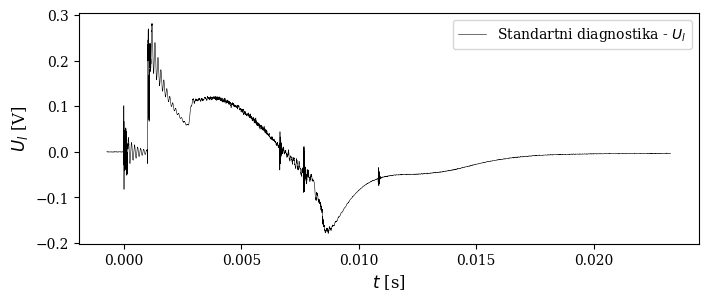

In [629]:
x = data_stdiag[shot]['time']
y = savgol_filter(data_stdiag[shot][parametr],20,5)

plt.figure(figsize = (8,3))

plt.plot(x,y, color = 'k', lw = '.4', label = legenda)

plt.legend(fontsize=10)

plt.ylabel(y_popisek, fontsize=12)
plt.xlabel(x_popisek, fontsize=12)

plt.savefig('{}.pdf'.format(nazev), bbox_inches = 'tight')
plt.show()

### Mag. pole na case

In [74]:
B,B_err,t,t_err = [],[],[],[]

for shot in shots:
    B.append(data[shot]['Bt_mean'][0])
    B_err.append(data[shot]['Bt_mean'][1])
    t.append(data[shot]['t_e'])
    
t_err = unumpy.std_devs(t)
t = unumpy.nominal_values(t)

B[0] = -B[0]

In [75]:
legenda = r'Závislost mag. pole $B_t$ na $ \tau_\mathrm{e} $'

In [80]:
plt.figure(figsize = (8,5))

plt.errorbar(t,B, yerr=B_err, xerr = t_err ,elinewidth=.4, fmt = 'kx', linestyle = None, ecolor = "k",capsize=3, label = legenda)
#plt.scatter(phi4g,U4g,color = 'k',marker = 'x', label = "Namerena intenzita se zeleným filtrem")

plt.legend(loc='upper left', fontsize=10)

plt.xticks(np.arange(0.05,0.13,0.005), minor = True)

#plt.xticks(np.arange(0,46,5))
plt.yticks(np.arange(0.18,0.23,.005), minor = True)
#plt.yticks(np.arange(460,481,5))
#plt.ylim(196,199.2)

plt.ylabel("$B_\mathrm{t}$ " + "[T]", fontsize=12)
plt.xlabel(r"$ \tau_\mathrm{e} $ " + "[ms]", fontsize=12)

plt.savefig('BtTe2.pdf', bbox_inches = 'tight')
plt.show()

C:\Users\stepa\AppData\Local\Temp/ipykernel_14188/2797952562.py:19: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### Test discharge plot oscope

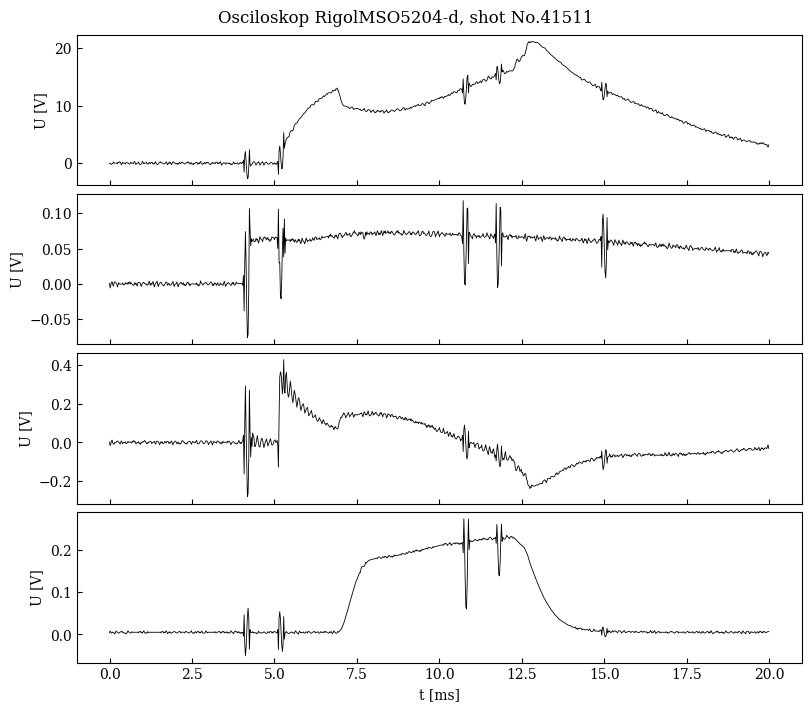

<Figure size 640x480 with 0 Axes>

In [43]:
    o = oscope
    shot = shots[1]
    
    plt_labels = ['$U_l$','$U_{Bt}$','$U_{RC}$','$U_{p}$']
    labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_photod']
   # data = []

    #for name in labels:
     #   data.append(load_oscope(shot,o,name)[1])
      #  t = load_oscope(shot,o,name)[0]
    
    t = data[shot]['time']

    fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(8, 7),sharex=True, layout="constrained")

    for i in range(4):
        axs[i].plot(t*1000,savgol_filter(data[shot][labels[i]],10,5), color = 'k', lw = .6)  ###20,5
        #axs[i//2][i%2].set_title(plt_labels[i])
        axs[i].set_ylabel('U [V]')
        axs[i].tick_params(direction = 'in')
        
    #axs[0][0].set_ylabel('U [V]')
    #axs[1][0].set_ylabel('U [V]')
    axs[3].set_xlabel('t [ms]')
  
    fig.suptitle('Osciloskop {}, shot No.{}'.format(osc[o],shot))
    
    #plt.subplots_adjust(hspace=.05)
    
    plt.show()
    
    plt.savefig('test5.pdf', bbox_inches = 'tight')
    

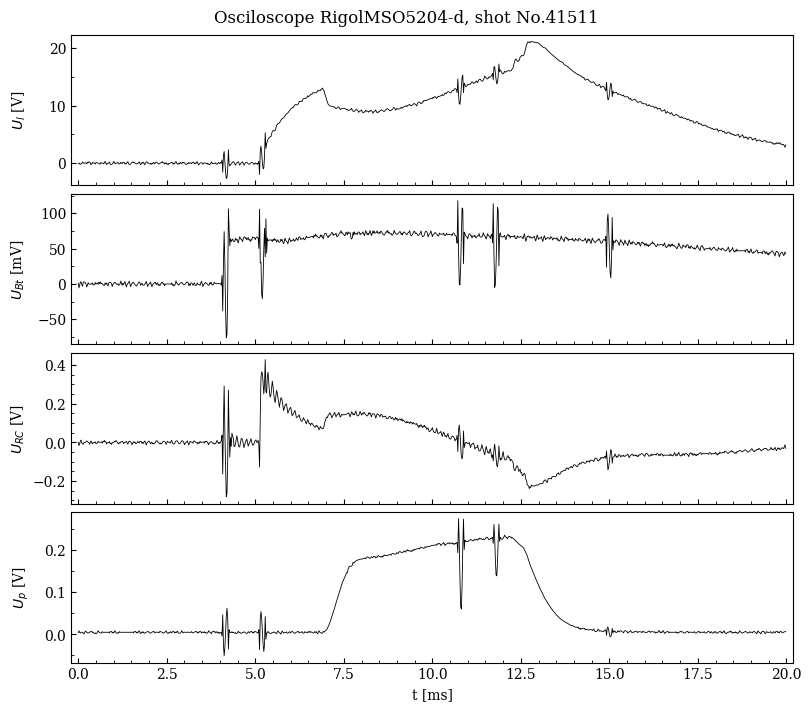

In [44]:
o = oscope
    
plt_labels = ['$U_l$','$U_{Bt}$','$U_{RC}$','$U_{p}$']
labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil', 'U_photod']
mul = [1,1000,1,1]
unit = ['V','mV','V','V']

t = data[shot]['time']

#data = []

#for name in labels:
    #data.append(load_oscope(shot,o,name)[1])
    #t = load_oscope(shot,o,name)[0]

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(8, 7),sharex=True,layout="compressed")

for i in range(4):
    axs[i].plot(t*1000,savgol_filter(data[shot][labels[i]],10,5)*mul[i], color = 'k', lw = .6)
    axs[i].set_ylabel(r'{} [{}]'.format(plt_labels[i], unit[i]))
    axs[i].tick_params(which = 'both',direction = 'in')

    
axs[3].set_xlabel('t [ms]')
axs[3].set_xticks(np.arange(0,20,0.5), minor=True)
axs[3].set_xlim(-0.2,20.2)

axs[0].set_yticks(np.arange(0,20,5), minor=True)
axs[1].set_yticks(np.arange(-75,126,25), minor=True)
axs[2].set_yticks(np.arange(-0.3,0.4,0.05), minor=True)
axs[3].set_yticks(np.arange(-0.05,0.3,0.05), minor=True)



axs[3].yaxis.labelpad = 10
axs[0].yaxis.labelpad = 15
axs[1].yaxis.labelpad = 7

#plt.subplots_adjust(hspace=.0)
fig.suptitle('Osciloscope {}, shot No.{}'.format(osc[o],shot))
    
plt.show()
#plt.savefig('final/test_discharge.pdf', bbox_inches = 'tight')

### Comparsion

In [93]:
o = oscope
    
plt_labels = ['$U_\mathrm{l}$','$U_\mathrm{Bt}$','$U_\mathrm{RC}$','$I_\mathrm{p}$','$B_\mathrm{t}$']
labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil','I_p', 'Bt']
#mul = [1,1000,1,1]
unit = ['V','mV','V','kA','T']

t = data[shot]['time'][k:l] - data[shot]['time'][k:l][0]
t_d = data_stdiag[shot]['time'][k_d:l_d] - data_stdiag[shot]['time'][k_d:l_d][0]

k, l = data[shot]['bounds']
k_d, l_d = data_stdiag[shot]['bounds']

#data = []

#for name in labels:
    #data.append(load_oscope(shot,o,name)[1])
    #t = load_oscope(shot,o,name)[0]

for j in range(len(labels)):
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 2),sharex=True, layout="constrained")

    for i in range(2):
    
        axs[1].plot(t_d[::4]*1000,savgol_filter(data_stdiag[shot][labels[j]],100,5)[k_d:l_d][::4], color = 'k', lw = .6)
        axs[0].plot(t*1000,savgol_filter(data[shot][labels[j]],20,5)[k:l], color = 'k', lw = .6)
    
        axs[0].set_ylabel(r'{} [{}]'.format(plt_labels[j], unit[j]))
        
        axs[i].tick_params(which = 'both',direction = 'in')
        axs[i].set_xlabel('t [ms]')
    
        axs[0].set_title("Our diagnostics")
        axs[1].set_title("Standart diagnostics")

    
    #axs[1].set_xlabel('t [ms]')
    #axs[1].set_xticks(np.arange(0,20,0.5), minor=True)
    #axs[1].set_xlim(-0.2,20.2)

    #axs[0].set_yticks(np.arange(0,20,5), minor=True)
    #axs[1].set_yticks(np.arange(-75,126,25), minor=True)

    #axs[3].yaxis.labelpad = 10
    #axs[0].yaxis.labelpad = 15
    #axs[1].yaxis.labelpad = 7

    #plt.subplots_adjust(hspace=.0)
    fig.suptitle('Shot No.{}'.format(shot))
    
    plt.show()
    #plt.savefig('final/test_discharge.pdf', bbox_inches = 'tight')
    plt.savefig('final/{}_horizontal.pdf'.format(labels[j]), bbox_inches = 'tight')

C:\Users\stepa\AppData\Local\Temp/ipykernel_1540/1417969728.py:52: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [92]:
o = oscope
    
plt_labels = ['$U_\mathrm{l}$','$U_\mathrm{Bt}$','$U_\mathrm{RC}$','$I_\mathrm{p}$','$B_\mathrm{t}$']
labels = ['U_Loop', 'U_BtCoil', 'U_RogCoil','I_p', 'Bt']
#mul = [1,1000,1,1]
unit = ['V','mV','V','kA','T']

k, l = data[shot]['bounds']
k_d, l_d = data_stdiag[shot]['bounds']

t = data[shot]['time'][k:l] - data[shot]['time'][k:l][0]
t_d = data_stdiag[shot]['time'][k_d:l_d] - data_stdiag[shot]['time'][k_d:l_d][0]

#data = []

#for name in labels:
    #data.append(load_oscope(shot,o,name)[1])
    #t = load_oscope(shot,o,name)[0]

for j in range(len(labels)):
    
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(8, 5),sharex=True, layout="constrained")

    for i in range(2):
    
        axs[1].plot(t_d*1000,savgol_filter(data_stdiag[shot][labels[j]],100,5)[k_d:l_d], color = 'k', lw = .6)
        axs[0].plot(t*1000,savgol_filter(data[shot][labels[j]],20,5)[k:l], color = 'k', lw = .6)
        
        axs[i].set_ylabel(r'{} [{}]'.format(plt_labels[j], unit[j]))
        
        axs[i].tick_params(which = 'both',direction = 'in')
        axs[1].set_xlabel('t [ms]')
    
        axs[0].set_title("Our diagnostics")
        axs[1].set_title("Standart diagnostics")

    
    #axs[1].set_xlabel('t [ms]')
    #axs[1].set_xticks(np.arange(0,20,0.5), minor=True)
    #axs[1].set_xlim(-0.2,20.2)

    #axs[0].set_yticks(np.arange(0,20,5), minor=True)
    #axs[1].set_yticks(np.arange(-75,126,25), minor=True)

    #axs[3].yaxis.labelpad = 10
    #axs[0].yaxis.labelpad = 15
    #axs[1].yaxis.labelpad = 7

    #plt.subplots_adjust(hspace=.0)
    #fig.suptitle('          Shot No.{}'.format(shot), ha = 'center', size = 'small')
    
    plt.show()
    plt.savefig('final/{}.pdf'.format(labels[j]), bbox_inches = 'tight')

C:\Users\stepa\AppData\Local\Temp/ipykernel_1540/1107253209.py:52: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


### fewrwe

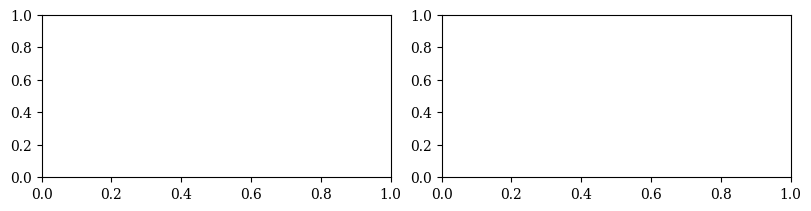

In [654]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(8, 2),sharex=True, layout="constrained")

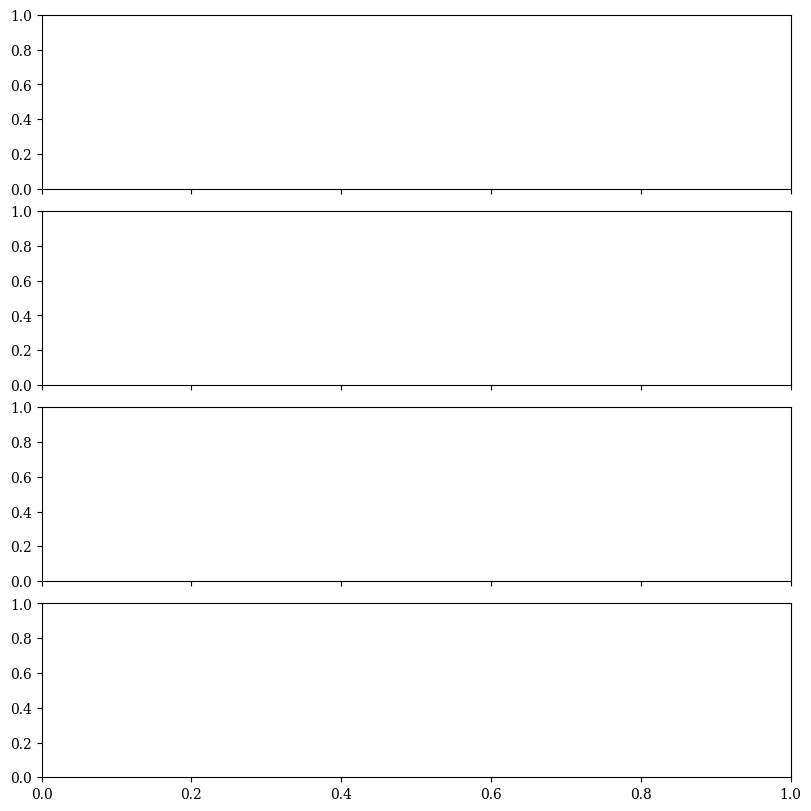

In [662]:
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(8, 8),sharex=True, layout="constrained")

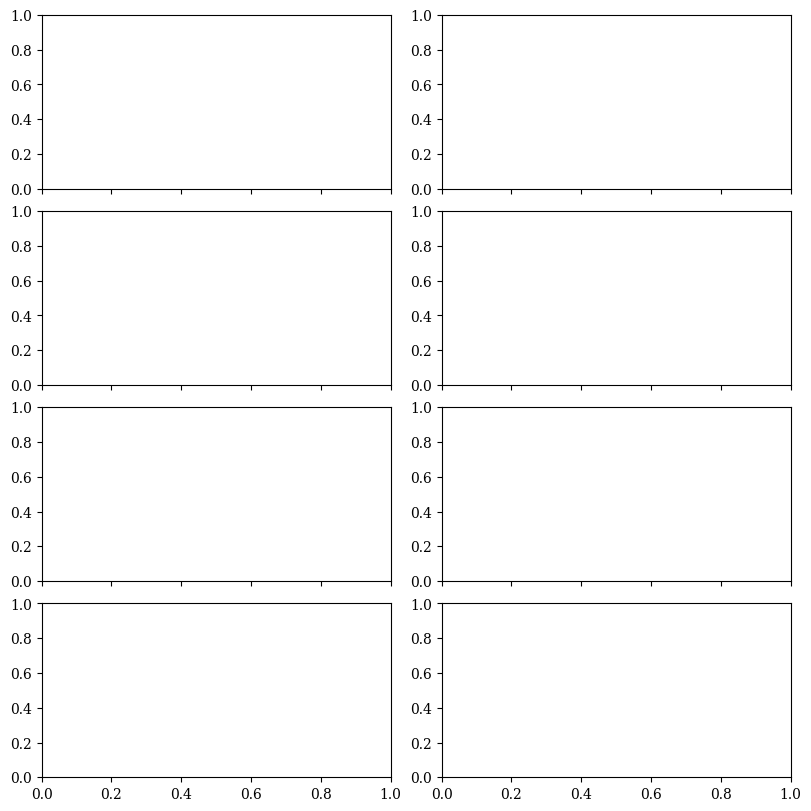

In [658]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(8, 8),sharex=True, layout="constrained")

In [649]:
shot = shots[1]

In [650]:
x1 = data[shot]['time']
x2 = data_stdiag[shot]['time']

y1 = data[shot]['U_BtCoil']
y2 = data_stdiag[shot]['U_BtCoil']

fig, axs = plt.subplots(ncols=2, figsize=(8, 2), layout="constrained")

axs[0].plot(x1,y1, color = 'k', lw = '.6')
axs[1].plot(x2,y2, color = 'k', lw = '.6')


IndexError: list index out of range

# **BORDEL**

#### Bordeeel

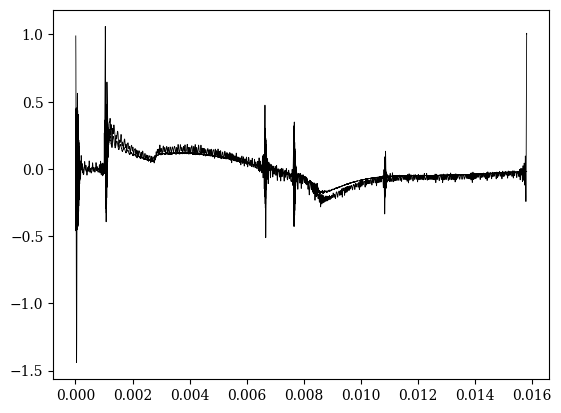

In [522]:
shot = shots[1]

t_d = data_stdiag[shot]['time']
y_d = data_stdiag[shot]['U_RogCoil']

k_d,l_d = data_stdiag[shot]['bounds']

k,l = data[shot]['bounds']
y = data[shot]['U_RogCoil'][k:l]

y_int = resample(y, len(t_d[k_d:l_d]))

plot(t_d[k_d:l_d],y_int)
plot(t_d[k_d:l_d],y_d[k_d:l_d])

In [523]:
len(t_d[k_d:l_d])

15820

In [524]:
l_d-k_d

15820

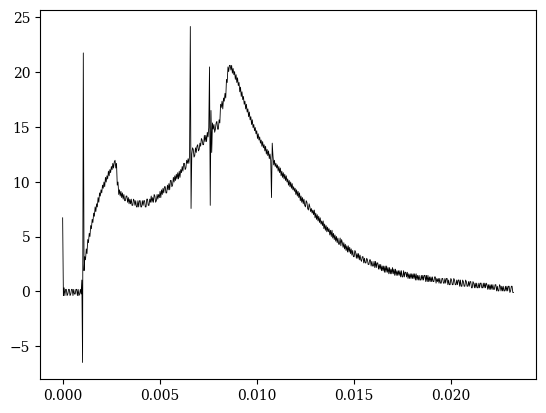

In [334]:
t = data[shot]['time']
y = data[shot]['U_Loop']

k,l = data[shot]['bounds']

plot(t[k:l],y[k:l])

SORRY, TOHLE JE FAKT PRASARNA

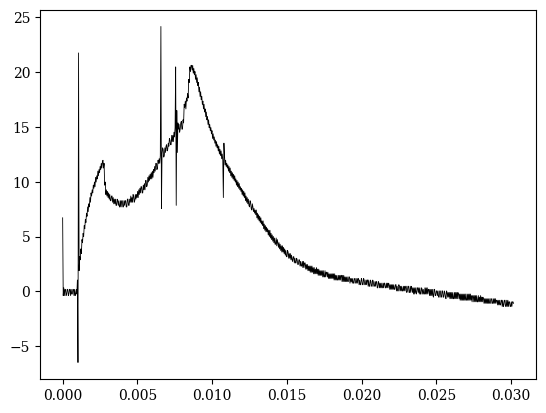

In [308]:
k = np.where(data[shots[1]]['U_Loop'] > 1)[0][0]

t_cut = data[shots[1]]['time'][k:]
t_cut -= t_cut[0]

plot(t_cut,data[shots[1]]['U_Loop'][k:]) 

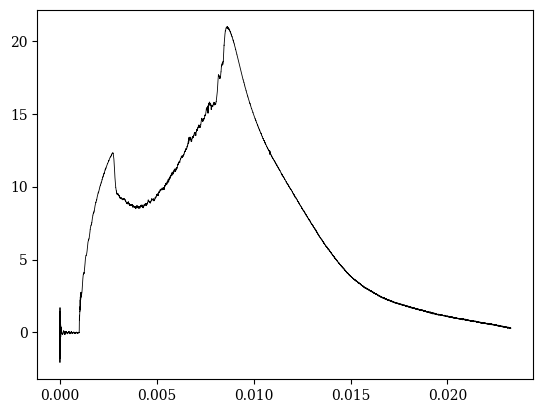

In [309]:
k_diag = np.where(data_stdiag[shots[1]]['U_Loop'] > 1)[0][0]

t_diag_cut = data_stdiag[shots[1]]['time'][k_diag:]
t_diag_cut -= t_diag_cut[0]

plot(t_diag_cut,data_stdiag[shots[1]]['U_Loop'][k_diag:]) 

In [310]:
lim = min(t_diag_cut[-1], t_cut[-1])
l = int(lim/step)
l_diag = int(lim/step_diag)


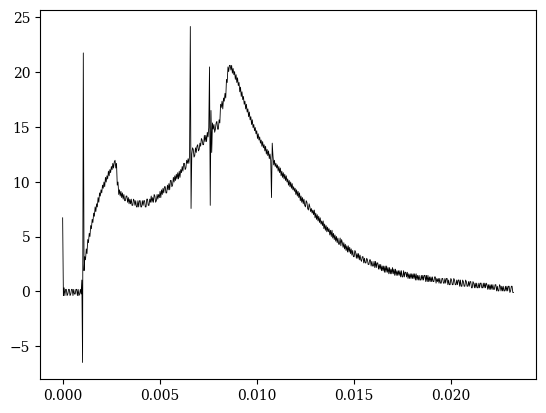

In [316]:
plot(t_cut[0:l],data[shots[1]]['U_Loop'][k:k+l])
plot(t_diag_cut[0:l_diag],data_stdiag[shots[1]]['U_Loop'][k_diag:k_diag+l_diag])

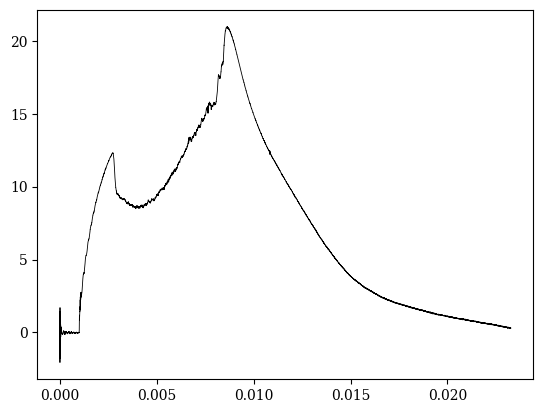

In [317]:
plot(t_diag_cut[0:l_diag],data_stdiag[shots[1]]['U_Loop'][k_diag:k_diag+l_diag])

In [130]:
a = np.array([1,2,3,4,5,6,7])
print(np.where(a<4))

(array([0, 1, 2], dtype=int64),)


In [36]:
diag_step = (t_diag[-1]-t_diag[0])/len(t_diag) ### nejmensi dilek std diag
step = t[-1]/len(t)

In [37]:
shift = (-t_diag[0])/diag_step

def index_transform(i):
    begin = (4*10**(-3))/step
    pos = (i-begin)/len(t) 
    index_std = pos*len(t_diag) + shift
    return(int(index_std))

In [38]:
print(np.mean((data[shots[0]]['U_Loop'][207:999]))*1000)
print(np.mean(data_stdiag[shots[0]]['U_Loop'][index_transform(207):index_transform(999)]+4/1000)*1000)

-32.048113510101516
7460.993436455274


In [39]:
Crc_arr = []

for shot in shots:
    Irc = np.mean(cumulative_trapezoid(data[shot]['U_RogCoil'],data[shot]['time'],initial=0)[207:999])
    x = np.mean((data_stdiag[shot]['I_p'] + data_stdiag[shot]['U_Loop']/Rch)[index_transform(207):index_transform(999)])
    Crc_arr.append(x/Irc)
    
Crc = np.mean(Crc_arr)

In [58]:
Crc = 2758156

In [57]:
Crc_diag

5300000.0

In [59]:
1.5*2758156

4137234.0

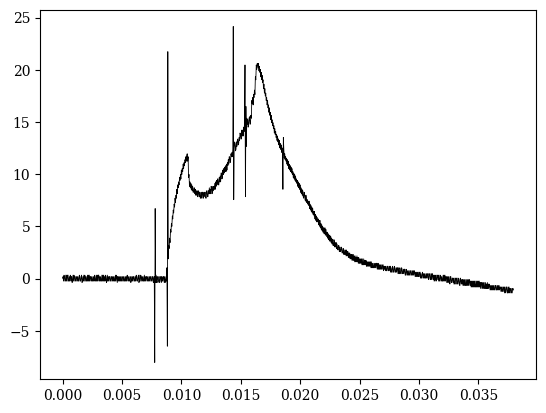

In [248]:
plot(data[shots[1]]['time'],data[shots[1]]['U_Loop']) 
#plt.xlim(0.04,000.05)

(-3.0, 3.0)

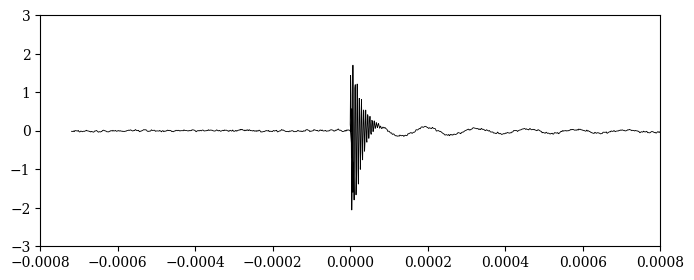

In [249]:
plt.figure(figsize = (8,3))
plot(data_stdiag[shots[4]]['time'],data_stdiag[shots[1]]['U_Loop']) 
plt.xlim(-0.0008,0.0008)
plt.ylim(-3,3)

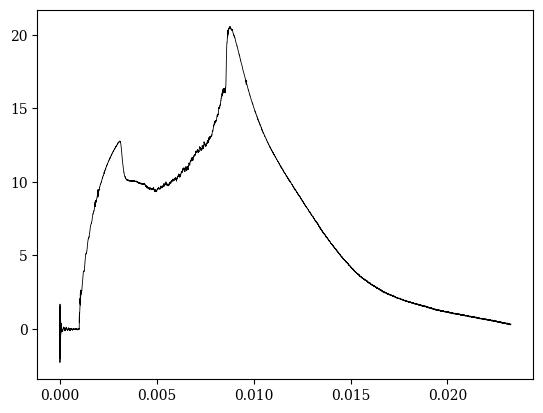

In [252]:
k_diag = np.where(data_stdiag[shots[4]]['U_Loop'] > 1)[0][0]
plot(data_stdiag[shots[4]]['time'][k_diag:],data_stdiag[shots[4]]['U_Loop'][k_diag:]) 

## Calculation of $R_{ch}$

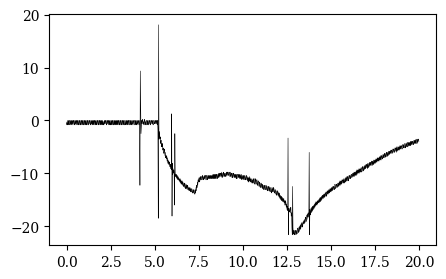

In [260]:
t,Ul = load_oscope(shot,oscope,'U_Loop')

plt.figure(figsize = (5,3))
plt.plot(t*1000,Ul, color = 'k', lw = '.4')

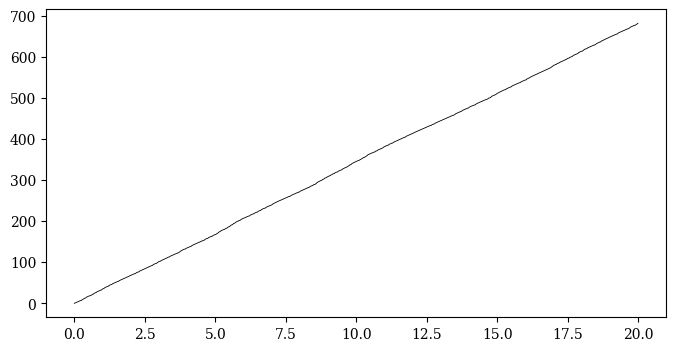

In [192]:
t,Urc = load_oscope(shot,oscope,'U_RogCoil')

Ich = -Crc * cumulative_trapezoid(Urc,t,initial=0)

plt.figure(figsize = (8,4))
plt.plot(t*1000,Ich, color = 'k', lw = '.6')

## Chamber current $I_{ch}$

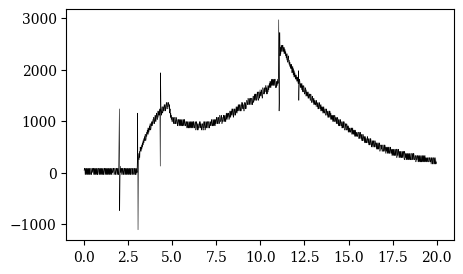

In [294]:
#t,Ul = load(shot,'U_Loop')
t,Ul = load_oscope(shot,oscope,'U_Loop')


Ich = -Ul/0.0097

plt.figure(figsize = (5,3))
plt.plot(t*1000,Ich, color = 'k', lw = '.4')

## Calculating $B_t$

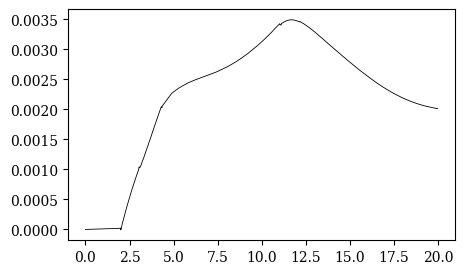

In [295]:
#t,Ubt = load(shot,'U_BtCoil')
t,Ubt = load_oscope(shots,'a','U_BtCoil')

Bt = -cumulative_trapezoid(Ubt,t,initial=0)

plt.figure(figsize = (5,3))
plt.plot(t*1000,Bt, color = 'k', lw = '.6')

## Plasma current $I_{p}$

## Measured current $I_{p+ch}$

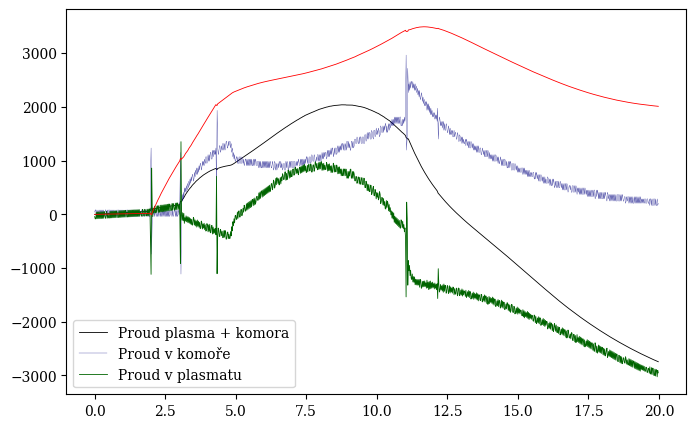

In [296]:
#t,Urc = load(shot,'U_RogCoil')
t,Urc = load_oscope(shot,oscope,'U_RogCoil')

Ipch = -Crc * cumulative_trapezoid(Urc,t,initial=0)

Ip = Ipch - Ich

plt.figure(figsize = (8,5))
plt.plot(t*1000,Ipch, color = 'k', lw = '.6',label = 'Proud plasma + komora')
plt.plot(t*1000,Ich, color = 'navy', lw = '.2',label = 'Proud v komoře')
plt.plot(t*1000,Ip, color = 'darkgreen', lw = '.6',label = 'Proud v plasmatu')
plt.plot(t*1000,Bt*1000000, color = 'r', lw = '.6')

plt.legend()

## $I_{p}$ calculation

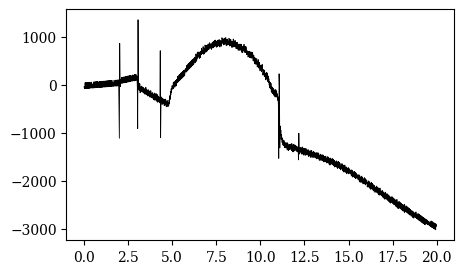

In [298]:
Ip = Ipch - Ich

plt.figure(figsize = (5,3))
plt.plot(t*1000,Ip, color = 'k', lw = '.6')

# NOTES

**Zeptat se:**
* Co jsou časy $t_{Bt}$ a $t_{CD}$?
* Jak je využít k odpočtu ofsetu?
* Co měřím pomocí osciloskopu?
* Rozdíl mezi Osciloskopem a Diagnostikou
* Konstanty beru z dat (Crc atd.)?
* Beru R ze zadani nebo urcuji z dat podle diagramu?
* CO JE SAKRA KVAZISTACIONARNI FAZE?????
* Přes co středuju? Jak ten čas určím?
* Polarity CD,CW